In [1]:
import tensorflow as tf

def precision(y_true, y_pred):
    true_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true * y_pred, 0, 1)))
    predicted_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + tf.keras.backend.epsilon())
    return precision

def recall(y_true, y_pred):
    true_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true * y_pred, 0, 1)))
    possible_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + tf.keras.backend.epsilon())
    return recall

def f1_score(y_true, y_pred):
    precision_val = precision(y_true, y_pred)
    recall_val = recall(y_true, y_pred)
    return 2 * ((precision_val * recall_val) / (precision_val + recall_val + tf.keras.backend.epsilon()))

In [3]:
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, concatenate, Dropout, BatchNormalization
from keras.models import Model

def create_siamese_cnn_binary(input_shape):
    # Define input layers
    input_left = Input(shape=input_shape)
    input_right = Input(shape=input_shape)

    # Shared convolutional layers
    def shared_network(input_tensor):
        x = Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same')(input_tensor)
        x = BatchNormalization()(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        
        x = Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same')(x)
        x = BatchNormalization()(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)

        x = Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same')(x)
        x = BatchNormalization()(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        
        x = Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same')(x)
        x = BatchNormalization()(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)

        x = Flatten()(x)

        x = Dense(1024, activation='relu')(x)
        x= Dropout(0.1)(x)
    

        x = Flatten()(x)
        
        return x

    # Process left input
    x1 = shared_network(input_left)

    # Process right input
    x2 = shared_network(input_right)

    # Concatenate the processed inputs
    concatenated = concatenate([x1, x2])
    
    # Output layer for binary classification
    output = Dense(1, activation='sigmoid')(concatenated)

    # Create Siamese CNN model
    siamese_model = Model(inputs=[input_left, input_right], outputs=output)

    return siamese_model


In [4]:
siamese_model=create_siamese_cnn_binary((224,224,3))
# Compile the fused model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
siamese_model.compile(optimizer=optimizer,
                    loss='binary_crossentropy',
                    metrics=['accuracy', precision, recall, f1_score])

# Print model summary
siamese_model.summary()



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 224, 224, 32)         896       ['input_1[0][0]']             
                                                                                                  
 conv2d_4 (Conv2D)           (None, 224, 224, 32)         896       ['input_2[0][0]']             
                                                                                            

In [5]:
import os
import numpy as np
from keras.preprocessing import image

def load_images_from_directory(directory, target_size):
    images = []
    labels = []
    label_map = {'normal': 0, 'abnormal': 1}
    
    for label in label_map.keys():
        label_dir = os.path.join(directory, label)
        for img_file in os.listdir(label_dir):
            img_path = os.path.join(label_dir, img_file)
            img = image.load_img(img_path, target_size=target_size)
            img_array = image.img_to_array(img)
            img_array *= (1.0/255)  # Apply rescaling
            images.append(img_array)
            labels.append(label_map[label])
            
    return np.array(images), np.array(labels)

In [6]:
# Define path to main directory containing normal and abnormal subdirectories
ECG_path = r"E:\MAIN PROJECT\FILTERD CODES\data splitting\scalogram data\ECG_scalogram_divided"
PCG_path = r"E:\MAIN PROJECT\FILTERD CODES\data splitting\scalogram data\PCG_scalogram_divided"

In [7]:
# Load actual data arrays for ECG and PCG

X_ecg, y_ecg = load_images_from_directory(ECG_path, target_size=(224, 224))
X_pcg, y_pcg = load_images_from_directory(PCG_path, target_size=(224, 224))

In [8]:
from sklearn.model_selection import train_test_split

# Split the data into training and validation sets
X_train_ecg, X_val_ecg, y_train, y_val_ecg = train_test_split(X_ecg, y_ecg, test_size=0.2, random_state=41)
X_train_pcg, X_val_pcg, y_train, y_val_pcg = train_test_split(X_pcg, y_ecg, test_size=0.2, random_state=41)

In [9]:
print(y_val_pcg,y_val_ecg)

[1 0 0 1 1 0 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 0 1 0 1 0 0 1 1 1 1 1 1 1 1
 1 1 1 1 0 1 1 1 1 0 0 1 0 0 1 0 1 1 1 1 0 1 0 0 0 0 1 0 1 1 1 0 1 1 0 1 0
 1 1 1 1 0 1 1 1 1 1 0 1 0 0 1 1 1 1 1 1 1 0 0 1 0 1 1 1 1 1 0 1 1 1 1 1 1
 0 0 1 1 1 0 0 1 1 1 0 0 1 1 1 1 0 1 0 1 0 0 1 1 1 1 1 1 0 1 1 0 1 1 1 0 0
 1 0 0 0 1 0 0 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 0 1 0 0 1 1 0 0 1 1 1
 0 0 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 0 0 1 1 0 1 1 0 1 1 1 1 1 1 0 1 1 0 0
 1 1 0 1 0 0 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 0 0 1 1 0 1 1 1 1 1 1 1 1 0 0
 1 1 1 1 0 1 1 0 1 0 1 1 1 1 0 1 1 1 0 1 0 1 1 0 1 0 1 0 0 1 1 0 1 1 0 1 1
 1 0 1 1 1 1 1 0 1 1 1 0 1 1 0 1 1 1 1 0 1 0 0 1 1 1 1 1 0 1 0 1 1 1 1 1 1
 1 0 1 1 1 1 1 1 0 1 0 1 1 1 1 0 1 0 1 1 1 1 1 0 1 1 0 1 1 0 1 1 1 1 1 1 0
 0 1 1 1 1 0 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 0 1 1 1 0 0 0 1
 1 0 0 0 1 0 0 1 1 1 0 0 0 1 0 1 0 1 1 1 1 1 0 1 1 0 0 1 1 0 1 1 1 1 1 1 1
 1 1 1 0 1 1 0 0 1 1 0 1 1 1 1 1 0 0 1 1 1 1 0 1 1 0 1 0 0 1 0 0 0 0 1 1 0
 1 0 1 0 1 1 1 1 1 1 1 1 

In [10]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint_callback = ModelCheckpoint(
    filepath="E:\\MAIN PROJECT\\FILTERD CODES\\data splitting\\trained models\\CNN_syamese\\CNN_fused_syamese\CNN_fused_syamese_epoch_{epoch}.keras",  # Save the model with the epoch number in the filename
    save_weights_only=False,  # Save the entire model (architecture, weights, and training configuration)
    save_best_only=False,  # Save the model after each epoch, regardless of performance
    monitor='val_loss',  # Quantity to monitor on the validation set
    mode='min',  # Mode can be 'min' or 'max' depending on whether you want to minimize or maximize the monitored quantity
    verbose=1
)


# Define a callback for early stopping
early_stopping_callback = EarlyStopping(
    monitor='val_loss',  # Quantity to monitor on the validation set
    patience=20,  # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True,  # Restore model weights from the epoch with the best value of the monitored quantity
    verbose=1
)
# Train the fused model
history = siamese_model.fit(
    [[X_train_ecg,X_train_pcg]], # Input data: PCG and ECG images
    y_train,                      # Target labels
    batch_size=64,                # Batch size
    epochs=100,                    # Number of epochs
    validation_data=([[X_val_ecg,X_val_pcg]], y_val_ecg),        # Fraction of training data used for validation
    callbacks=[early_stopping_callback]  # Callbacks for early stopping and model checkpoint
)

Epoch 1/100


44/44 [==============================] - 215s 4s/step - loss: 15.0893 - accuracy: 0.7156 - precision: 0.7947 - recall: 0.8063 - f1_score: 0.7823 - val_loss: 1.6540 - val_accuracy: 0.4138 - val_precision: 0.8447 - val_recall: 0.2131 - val_f1_score: 0.3384
Epoch 2/100
44/44 [==============================] - 168s 4s/step - loss: 0.3717 - accuracy: 0.8472 - precision: 0.8748 - recall: 0.9185 - f1_score: 0.8940 - val_loss: 3.2033 - val_accuracy: 0.4784 - val_precision: 0.8122 - val_recall: 0.3460 - val_f1_score: 0.4823
Epoch 3/100
44/44 [==============================] - 169s 4s/step - loss: 0.2671 - accuracy: 0.8846 - precision: 0.9004 - recall: 0.9445 - f1_score: 0.9205 - val_loss: 2.8606 - val_accuracy: 0.5920 - val_precision: 0.8256 - val_recall: 0.5394 - val_f1_score: 0.6495
Epoch 4/100
44/44 [==============================] - 165s 4s/step - loss: 0.2137 - accuracy: 0.9169 - precision: 0.9304 - recall: 0.9568 - f1_score: 0.9422 - val_loss: 2.1834 - val_accuracy: 0.6767 -

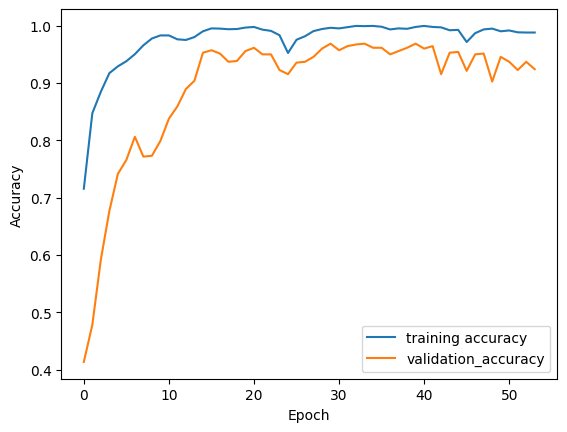

In [11]:
import matplotlib.pyplot as plt

# Plot training history
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='validation_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

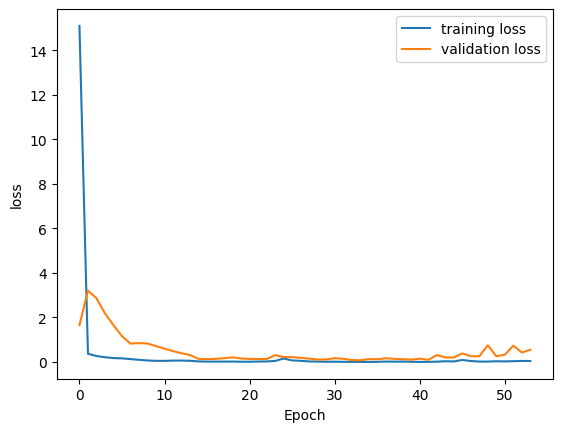

In [12]:
import matplotlib.pyplot as plt

# Plot training history
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.legend(loc='upper right')
plt.show()

In [13]:
siamese_model.save(r"E:\MAIN PROJECT\FILTERD CODES\data splitting\trained models\CNN_syamese\CNN_fused_syamese\CNN_fused_syamese_epoch_34.keras")

In [15]:
from tensorflow.keras.models import load_model
CNN_fused = load_model(r"E:\MAIN PROJECT\FILTERD CODES\data splitting\trained models\CNN_syamese\CNN_fused_syamese\CNN_fused_syamese_epoch_34.keras",custom_objects={'precision': precision, 'recall': recall, 'f1_score': f1_score})

In [16]:
y_pred_prob_train = CNN_fused.predict([X_train_ecg, X_train_pcg])

87/87 [==============================] - 49s 432ms/step


In [17]:
y_pred_train = np.round(y_pred_prob_train)

In [18]:
from sklearn.metrics import confusion_matrix
# Calculate the confusion matrix
cm_fused_train = confusion_matrix(y_train, y_pred_train)

print("cm ecg train:",cm_fused_train)

cm ecg train: [[ 805    0]
 [   0 1976]]


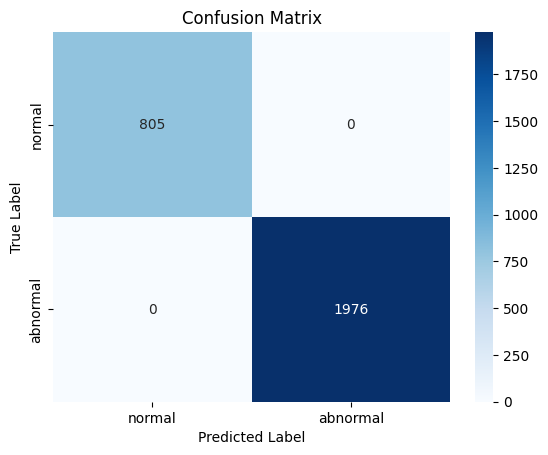

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       805
           1       1.00      1.00      1.00      1976

    accuracy                           1.00      2781
   macro avg       1.00      1.00      1.00      2781
weighted avg       1.00      1.00      1.00      2781



In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

# Visualize the confusion matrix with values
sns.heatmap(cm_fused_train, annot=True, fmt='d', cmap='Blues', xticklabels=['normal', 'abnormal'], yticklabels=['normal', 'abnormal'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

from sklearn.metrics import classification_report
# Print classification report
print("Classification Report:")
print(classification_report(y_train, y_pred_train))

In [20]:
y_pred_prob_val = CNN_fused.predict([X_val_ecg, X_val_pcg])

22/22 [==============================] - 10s 448ms/step


In [21]:
y_pred_val = np.round(y_pred_prob_val)

In [22]:
from sklearn.metrics import confusion_matrix
# Calculate the confusion matrix
cm_fused_val = confusion_matrix(y_val_ecg, y_pred_val)

print("cm fused val:",cm_fused_val)

cm fused val: [[187  13]
 [  9 487]]


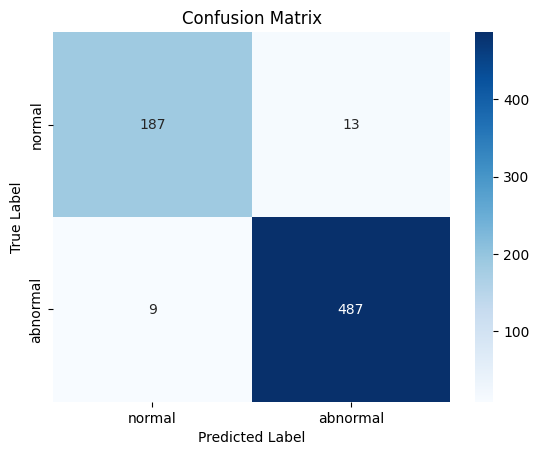

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.94      0.94       200
           1       0.97      0.98      0.98       496

    accuracy                           0.97       696
   macro avg       0.96      0.96      0.96       696
weighted avg       0.97      0.97      0.97       696



In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

# Visualize the confusion matrix with values
sns.heatmap(cm_fused_val, annot=True, fmt='d', cmap='Blues', xticklabels=['normal', 'abnormal'], yticklabels=['normal', 'abnormal'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

from sklearn.metrics import classification_report
# Print classification report
print("Classification Report:")
print(classification_report(y_val_ecg, y_pred_val))

In [24]:
def calculate_metrics(confusion_matrix):
    # Extract values from confusion matrix
    TP = confusion_matrix[1][1]
    FP = confusion_matrix[0][1]
    FN = confusion_matrix[1][0]
    TN = confusion_matrix[0][0]
    
    # Calculate precision
    precision = TP / (TP + FP) if (TP + FP) != 0 else 0
    
    # Calculate recall (sensitivity)
    recall = TP / (TP + FN) if (TP + FN) != 0 else 0
    
    # Calculate F1 score
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
    
    # Calculate accuracy
    accuracy = (TP + TN) / (TP + TN + FP + FN) if (TP + TN + FP + FN) != 0 else 0

    # Calculate specificity
    specificity = TN / (TN + FP) if (TN + FP) != 0 else 0
    
    return precision, recall, f1_score, accuracy,specificity

In [25]:
cm_fused_val=[[187 , 13],[  9 ,487]]
# Calculate metrics
val_precision, val_recall, val_f1_score, val_accuracy, val_specificity = calculate_metrics(cm_fused_val)

# Print results
print("Precision:", val_precision)
print("Recall (Sensitivity):", val_recall)
print("F1 Score:", val_f1_score)
print("Accuracy:", val_accuracy)
print("specificity:",val_specificity)

Precision: 0.974
Recall (Sensitivity): 0.9818548387096774
F1 Score: 0.9779116465863454
Accuracy: 0.9683908045977011
specificity: 0.935


In [22]:
cm_fused_train=[[ 805  ,  0],[   0, 1976]]
# Calculate metrics
train_precision, train_recall, train_f1_score, train_accuracy, train_specificity = calculate_metrics(cm_fused_train)

# Print results
print("Precision:", train_precision)
print("Recall (Sensitivity):", train_recall)
print("F1 Score:", train_f1_score)
print("Accuracy:", train_accuracy)
print("specificity:",train_specificity)

Precision: 1.0
Recall (Sensitivity): 0.9974696356275303
F1 Score: 0.998733215100076
Accuracy: 0.9982020855807263
specificity: 1.0


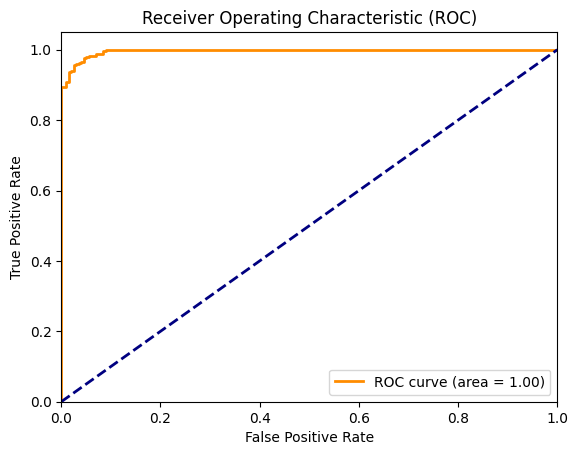

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc


# Compute ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(y_val_ecg, y_pred_prob_val)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

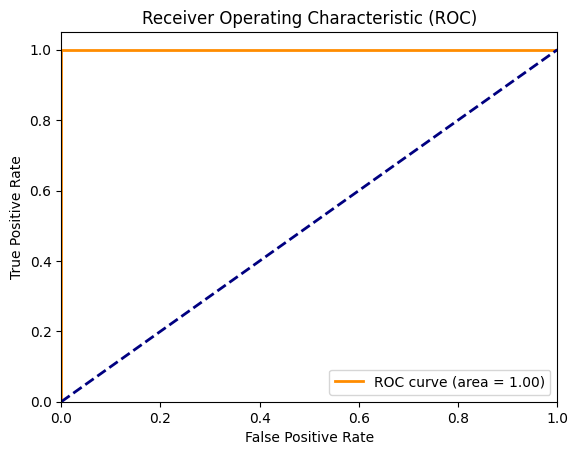

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc


# Compute ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(y_train, y_pred_prob_train)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

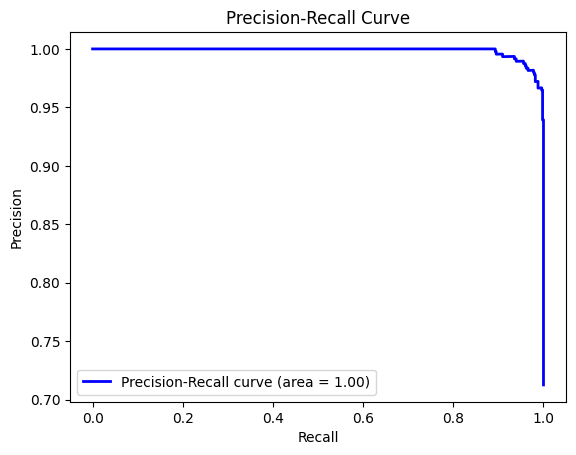

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc


# Calculate precision and recall
precision, recall, thresholds = precision_recall_curve(y_val_ecg, y_pred_prob_val)

# Compute area under the curve (AUC) for precision-recall curve
auc_score = auc(recall, precision)

# Plot precision-recall curve
plt.figure()
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % auc_score)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

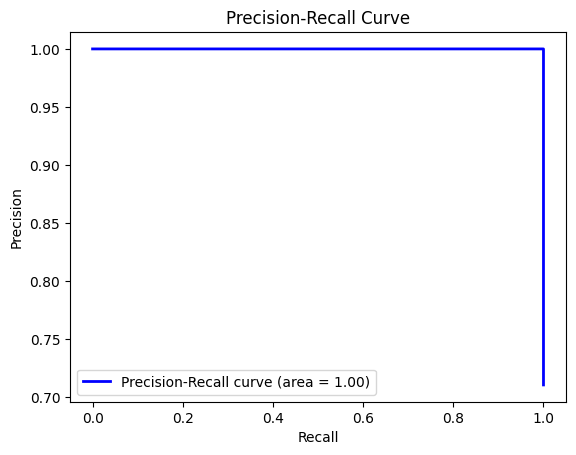

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc


# Calculate precision and recall
precision, recall, thresholds = precision_recall_curve(y_train, y_pred_prob_train)

# Compute area under the curve (AUC) for precision-recall curve
auc_score = auc(recall, precision)

# Plot precision-recall curve
plt.figure()
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % auc_score)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()